CBOW.py

In [1]:
import torch
import torch.nn as nn
text = """People who truly loved once are far more likely to love again.
Difficult circumstances serve as a textbook of life for people.
The best preparation for tomorrow is doing your best today.
The reason why a great man is great is that he resolves to be a great man.
The shortest way to do many things is to only one thing at a time.
Only they who fulfill their duties in everyday matters will fulfill them on great occasions. 
I go all out to deal with the ordinary life. 
I can stand up once again on my own.
Never underestimate your power to change yourself.""".split()

word = set(text)
word_size = len(word)

word_to_ix = {word:ix for ix, word in enumerate(word)}
ix_to_word = {ix:word for ix, word in enumerate(word)}

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

EMDEDDING_DIM = 100

data = []
for i in range(2, len(text) - 2):
    context = [text[i - 2], text[i - 1],
               text[i + 1], text[i + 2]]
    target = text[i]
    data.append((context, target))

class CBOW(torch.nn.Module):
    def __init__(self, word_size, embedding_dim):
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(word_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()

        self.linear2 = nn.Linear(128, word_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

model = CBOW(word_size, EMDEDDING_DIM)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#开始训练
for epoch in range(100):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

#预测
context1 = ['preparation','for','is', 'doing']
context_vector1 = make_context_vector(context1, word_to_ix)
a = model(context_vector1)

context2 = ['People','who', 'loved', 'once']
context_vector2 = make_context_vector(context2, word_to_ix)
b = model(context_vector2)

print(f'文本数据: {" ".join(text)}\n')
print(f'预测1: {context1}\n')
print(f'预测结果: {ix_to_word[torch.argmax(a[0]).item()]}')
print('\n')
print(f'预测2: {context2}\n')
print(f'预测结果: {ix_to_word[torch.argmax(b[0]).item()]}')


文本数据: People who truly loved once are far more likely to love again. Difficult circumstances serve as a textbook of life for people. The best preparation for tomorrow is doing your best today. The reason why a great man is great is that he resolves to be a great man. The shortest way to do many things is to only one thing at a time. Only they who fulfill their duties in everyday matters will fulfill them on great occasions. I go all out to deal with the ordinary life. I can stand up once again on my own. Never underestimate your power to change yourself.

预测1: ['preparation', 'for', 'is', 'doing']

预测结果: tomorrow


预测2: ['People', 'who', 'loved', 'once']

预测结果: truly


skip-gram.py

['i', 'like', 'dog', 'i', 'like', 'cat', 'i', 'like', 'animal', 'dog', 'cat', 'animal', 'apple', 'cat', 'dog', 'like', 'dog', 'fish', 'milk', 'like', 'dog', 'cat', 'eyes', 'like', 'i', 'like', 'apple', 'apple', 'i', 'hate', 'apple', 'i', 'movie', 'book', 'music', 'like', 'cat', 'dog', 'hate', 'cat', 'dog', 'like']
[5, 1, 6, 5, 1, 12, 5, 1, 4, 6, 12, 4, 2, 12, 6, 1, 6, 0, 8, 1, 6, 12, 7, 1, 5, 1, 2, 2, 5, 3, 2, 5, 10, 9, 11, 1, 12, 6, 3, 12, 6, 1]
{5: 0.14285714285714285, 1: 0.21428571428571427, 6: 0.16666666666666666, 12: 0.14285714285714285, 4: 0.047619047619047616, 2: 0.09523809523809523, 0: 0.023809523809523808, 8: 0.023809523809523808, 7: 0.023809523809523808, 3: 0.047619047619047616, 10: 0.023809523809523808, 9: 0.023809523809523808, 11: 0.023809523809523808}
tensor([0.1306, 0.1770, 0.1466, 0.1306, 0.0573, 0.0963, 0.0341, 0.0341, 0.0341,
        0.0573, 0.0341, 0.0341, 0.0341], dtype=torch.float64)
loss： tensor(3.0754, grad_fn=<NegBackward0>)
loss： tensor(2.8992, grad_fn=<NegBackw

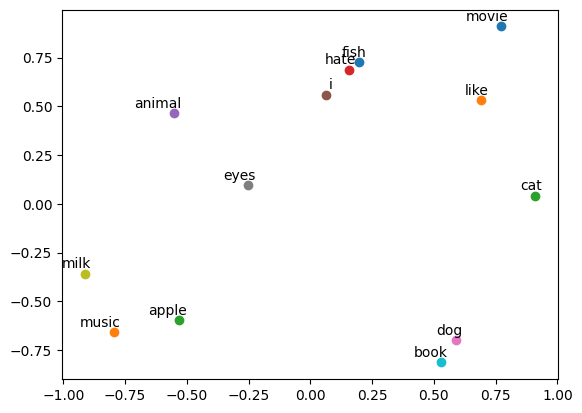

In [2]:
# conding = utf-8
"""
@目的：学习并实现skip-gram模型
"""

import numpy as np
import torch
from torch import nn, optim
import random
from collections import Counter
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
#训练数据
text = "I like dog i like cat i like animal dog cat animal apple cat dog like dog fish milk like dog \
cat eyes like i like apple apple i hate apple i movie book music like cat dog hate cat dog like"

#参数设置
EMBEDDING_DIM = 2 #词向量维度
PRINT_EVERY = 10 #可视化频率
EPOCHS = 10 #训练的轮数
BATCH_SIZE = 5 #每一批训练数据大小
N_SAMPLES = 3 #负样本大小
WINDOW_SIZE = 5 #周边词窗口大小
FREQ = 0 #词汇出现频率（可以删除低频词）
DELETE_WORDS = False #是否删除部分高频词

#文本预处理
def preprocess(text, FREQ):
    text = text.lower()      #有的会大写，有的小写，用小写进行统一
    words = text.split()
    #去除低频词
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > FREQ]     #保留频率大于给定值的词
    return trimmed_words
words = preprocess(text, FREQ)
print(words)

#构建词典
vocab = set(words)
vocab2int = {w: c for c, w in enumerate(vocab)}   # 给每个单词进行编号，构建一个词典
int2vocab = {c: w for c, w in enumerate(vocab)}
#将文本转化为数值
int_words = [vocab2int[w] for w in words]         # 根据词典的词的索引，将文本转换为编号
print(int_words)

#计算单词频次
int_word_counts = Counter(int_words)
total_count = len(int_words)
word_freqs = {w: c/total_count for w, c in int_word_counts.items()}
print(word_freqs)


#去除出现频次高的词汇
if DELETE_WORDS:
    t = 1e-5
    prob_drop = {w: 1-np.sqrt(t/word_freqs[w]) for w in int_word_counts}        # 过采样计算公式
    train_words = [w for w in int_words if random.random()<(1-prob_drop[w])]    #
else:
    train_words = int_words  # [2,4,7,...]

#单词分布
word_freqs = np.array(list(word_freqs.values()))    # 取到值放到list中，然后再放到数组中
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75)))     # 将numpy中的数组转换为tensor
print(noise_dist)

#获取目标词汇
def get_target(words, idx, WINDOW_SIZE):    #中心词（被转换为数字），中心词对应的id，窗口大小
  target_window = np.random.randint(1, WINDOW_SIZE+1)    # 数据很多的时候，可以随机调整窗口大小，减轻计算压力
  start_point = idx-target_window if (idx-target_window)>0 else 0      # 中心词前面的词
  end_point = idx+target_window                                        # 中心词后面的词
  targets = set(words[start_point:idx]+words[idx+1:end_point+1])       # targets表示背景词，是给定中心词，需要预测得目标
  return list(targets)

#批次化数据
def get_batch(words, BATCH_SIZE, WINDOW_SIZE):
  n_batches = len(words)//BATCH_SIZE
  words = words[:n_batches*BATCH_SIZE]
  for idx in range(0, len(words), BATCH_SIZE):
    batch_x, batch_y = [],[]
    batch = words[idx:idx+BATCH_SIZE]    # 将words分为一个一个batch
    for i in range(len(batch)):
      x = batch[i]
      y = get_target(batch, i, WINDOW_SIZE)    #
      batch_x.extend([x]*len(y))       # 中心词扩张，因为一个中心词对应多个周边词   类似于append()
      batch_y.extend(y)
    yield batch_x, batch_y

#定义模型
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist):
        super().__init__()
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        #定义词向量层
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        #词向量层参数初始化
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
    #输入词的前向过程
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors                                # 公式中的V_w
    #目标词的前向过程
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors                              # 公式中的U_c
    #负样本词的前向过程
    def forward_noise(self, size, N_SAMPLES):
        noise_dist = self.noise_dist
        #从词汇分布中采样负样本
        noise_words = torch.multinomial(noise_dist,           # 每个词出现的权重（分布）
                                        size * N_SAMPLES,
                                        replacement=True)     # 有放回的采样
        noise_vectors = self.out_embed(noise_words).view(size, N_SAMPLES, self.n_embed)
        return noise_vectors

#定义损失函数
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        BATCH_SIZE, embed_size = input_vectors.shape
        #将输入词向量与目标词向量作维度转化处理
        input_vectors = input_vectors.view(BATCH_SIZE, embed_size, 1)
        output_vectors = output_vectors.view(BATCH_SIZE, 1, embed_size)
        #目标词损失
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()  #（B,1,1）
        out_loss = out_loss.squeeze()
        # 降维为 B     torch.squeeze() 这个函数主要对数据的维度进行压缩，去掉维数为1的的维度，比如是一行或者一列这种，一个一行三列（1,3）的数去掉第一个维数为一的维度之后就变成（3）行
        #负样本损失
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)   #多个负样本，所以要加和
        #综合计算两类损失
        return -(out_loss + noise_loss).mean()

#模型、损失函数及优化器初始化
model = SkipGramNeg(len(vocab2int), EMBEDDING_DIM, noise_dist=noise_dist)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

#训练
steps = 0
for e in range(EPOCHS):
    #获取输入词以及目标词
    for input_words, target_words in get_batch(train_words, BATCH_SIZE, WINDOW_SIZE):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        #输入、输出以及负样本向量
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        size, _ = input_vectors.shape
        noise_vectors = model.forward_noise(size, N_SAMPLES)
        #计算损失
        loss = criterion(input_vectors, output_vectors, noise_vectors)
        #打印损失
        if steps%PRINT_EVERY == 0:
            print("loss：",loss)
        #反向传播更新权重
        optimizer.zero_grad()  # 损失置0，每epoch的损失无关，所以每次需要至零。
        loss.backward()        # 回传
        optimizer.step()       # 更新参数

#可视化词向量
for i, w in int2vocab.items():
    vectors = model.state_dict()["in_embed.weight"]     # 选择先前定义的in_embed.weight
    x,y = float(vectors[i][0]),float(vectors[i][1])     # 词向量的两个维度，因为前面定义EMBEDDING_DIM = 2
    plt.scatter(x,y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

